# Support Vectors Classifier

The following code trains a C-support vectors classifier.

In [1]:
# Config
from pi_pact_sort import categorize, bin_categorize

FEATURES: list = ['RSSI', 'HUMIDITY', 'PRESSURE'] # Contains strings 'RSSI', 'HUDMITIY', and/or 'PRESSURE'
CATEGORIZE_FUNC = bin_categorize # One of the two binning functions in pi_pact_sort.py

# Automatically configure other variables
if len(FEATURES) > 1:
    if len(FEATURES) == 2:
        if 'HUMIDITY' in FEATURES:
            feature_str = '3varH'
        else:
            feature_str = '3varP'
    else:
        feature_str = '4var'
else:
    feature_str = '2var'

if CATEGORIZE_FUNC == categorize:
    label_str = '3b'
else:
    label_str = 'binary'

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVC

DROP_COLUMNS = ['ADDRESS', 'TIMESTAMP', 'UUID', 'MAJOR', 'MINOR', 'TX POWER', 'TEMPERATURE',  
                'PITCH', 'ROLL', 'YAW', 'SCAN']
for feature in ['RSSI', 'HUMIDITY', 'PRESSURE']:
    if feature not in FEATURES:
        DROP_COLUMNS.append(feature)
SAMPLE_SIZE = 30000
np.random.seed(0)


"""Trains a Support Vectors classifier to predict a distance range given RSSI values and other variables.
"""

# Initialize DataFrame
data: pd.DataFrame = pd.DataFrame(columns=['DISTANCE', ] + FEATURES)
data_copy: pd.DataFrame = data.copy()
csv_file: Path
for csv_file in Path('.').glob('indoor-noObstruct-SenseHat*/*.csv'):
    datapart: pd.DataFrame = pd.read_csv(csv_file)
    for column in DROP_COLUMNS:
        if column in datapart.columns:
            datapart = datapart.drop([column], 1)
    data_copy = data_copy.append(datapart)

# Categorize distance
data_copy['DISTANCE'] = data_copy['DISTANCE'].map(CATEGORIZE_FUNC)

# Sample data from each distance category
for value in data_copy['DISTANCE'].unique():
    datapart = data_copy[data_copy.DISTANCE == value]
    datapart = datapart.sample(SAMPLE_SIZE, random_state=1)
    data = data.append(datapart)

# Assign features and labels
X: np.array = data.drop(['DISTANCE'], 1).to_numpy(dtype='float32')
y: np.array = data['DISTANCE'].to_numpy(dtype=int)

# Preprocessing
steps = [('min_max', MinMaxScaler()),
         ('interactions', PolynomialFeatures(interaction_only=True,
                                             include_bias=False))]
if len(FEATURES) > 1:
    steps.append(('dim_reduce', PCA()))
preprocessing = Pipeline(steps=steps)
pipe = Pipeline(steps=[('preprocessing', preprocessing),
                       ('model', SVC(random_state=1))])

In [3]:
# Hyperparameter tuning
param_grid = {'model__C': [1, 10],
              'model__kernel': ['rbf',]}
if len(FEATURES) > 1:
    param_grid.update({'preprocessing__dim_reduce__n_components': [5,]})#i for i in range(2, 2**len(FEATURES)-1)]})

grid = GridSearchCV(pipe, param_grid, n_jobs=2)
grid.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('min_max',
                                                         MinMaxScaler()),
                                                        ('interactions',
                                                         PolynomialFeatures(include_bias=False,
                                                                            interaction_only=True)),
                                                        ('dim_reduce',
                                                         PCA())])),
                                       ('model', SVC(random_state=1))]),
             n_jobs=2,
             param_grid={'model__C': [1, 10], 'model__kernel': ['rbf'],
                         'preprocessing__dim_reduce__n_components': [5]})

In [4]:
# Print optimal parameters and accuracy
print(grid.best_params_)
print('accuracy =', grid.best_score_)

{'model__C': 10, 'model__kernel': 'rbf', 'preprocessing__dim_reduce__n_components': 5}
accuracy = 0.9608333333333334


In [5]:
# Pickle model
import pickle
with open(f"svm-models/{feature_str}-{label_str}-polyFeatures-dimReduce-svm-model.pickle", "wb") as f:
    pickle.dump(grid.best_estimator_, f)

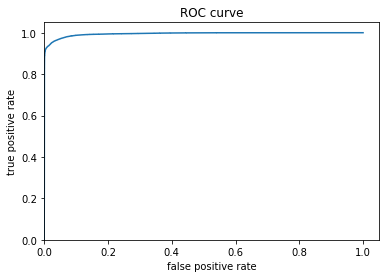

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Plot an ROC curve
if CATEGORIZE_FUNC == bin_categorize:
    probs = grid.best_estimator_.decision_function(X)
    fpr, tpr, _ = roc_curve(y, probs)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.xlim(0,)
    plt.ylim(0,)
    plt.savefig(str(Path(f'svm-models/{feature_str}-{label_str}-polyFeatures-dimReduce-svm-model-roc-curve.png')))